# toycode로 MDNs 를 이해해 보자 - 1



## 이 노트북에서는 MDN 이전에 여러 실험을 해본다. 

- 원문링크: http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/


## MDN 관련 링크
    
- 비숍: http://publications.aston.ac.uk/373/1/NCRG_94_004.pdf
- 참고장표: http://www.cedar.buffalo.edu/~srihari/CSE574/Chap5/Chap5.7-MixDensityNetworks.pdf
- 정연우님 구현: https://github.com/maestrojeong/Machine_learning
- 토이코드 구현참고 (나름 쉽게 풀어놓은듯): http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

## mean squared error로 가능한 경우

### 즉, 하나의 입력 x에 하나의 출력 y가 쌍으로 있다.

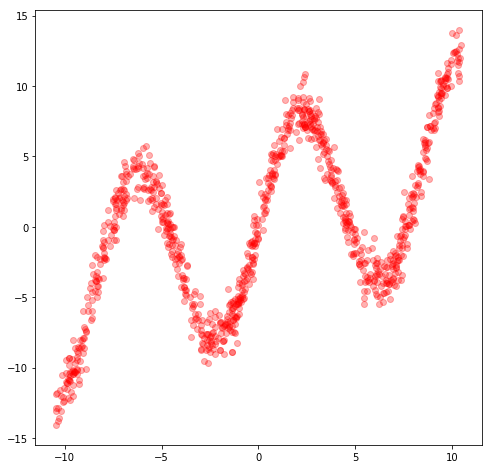

In [19]:
##############################################################
# 우리가 목표로 할 그래프 생성
##############################################################

NSAMPLE = 1000
x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_data = np.float32(np.random.normal(size=(NSAMPLE,1)))  # 랜덤 노이즈이다
y_data = np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

## train set

- 위와 같은 train set을 만들면 하나의 x 값에 하나의 y값이 매칭되는 것을 알 수 있다.
- 이처럼 train을 위한 1000개에 데이터를 만들어두었다.

In [20]:

x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,1])


In [21]:
##############################################################
# hidden_layer, y_out
##############################################################

NHIDDEN = 20
W = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))
b = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))

W_out = tf.Variable(tf.random_normal([NHIDDEN,1], stddev=1.0, dtype=tf.float32))
b_out = tf.Variable(tf.random_normal([1,1], stddev=1.0, dtype=tf.float32))

# [None, 1] 과 [1, NHIDDEN] 을 행렬곱했으니 출력은 [None, NHIDDEN]
hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)

# [None, NHIDDEN] 과 [NHIDDEN, 1]을 행렬곱했으니 출력은 [None, 1]
# 즉 입력되는 x의 개수만큼 출력이 된다
y_out = tf.matmul(hidden_layer,W_out) + b_out

In [22]:
##############################################################
# train, optimizer
##############################################################

lossfunc = tf.nn.l2_loss(y_out-y)  
train_op = tf.train.RMSPropOptimizer(learning_rate=0.1, decay=0.8).minimize(lossfunc)  

### 위쪽은 그래프를 만든것이고
### 여기서부터 실제로 Session run

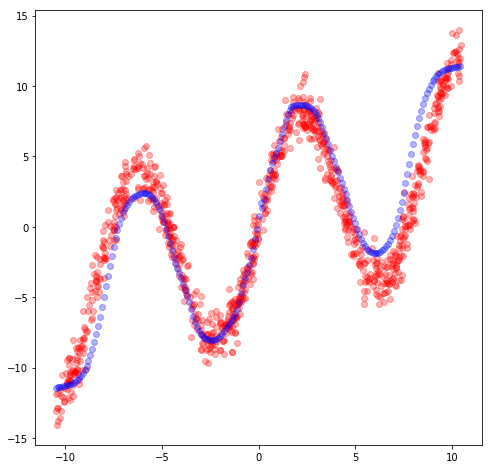

In [24]:
with tf.Session()  as sess:
    sess.run(tf.global_variables_initializer())

    NEPOCH = 1000  # 전체 train set 1000개에 대하여 1000번 돌린다
    for i in range(NEPOCH):
        sess.run(train_op, feed_dict={x: x_data, y: y_data})

    # 테스트
    x_test = np.float32(np.arange(-10.5, 10.5, 0.1))  # 총 210개의 x_test 입력
    x_test = x_test.reshape(x_test.size, 1)
    y_test = sess.run(y_out, feed_dict={x: x_test})

    plt.figure(figsize=(8, 8)) # 8인치, 8인치 https://www.labri.fr/perso/nrougier/teaching/matplotlib/#figures-subplots-axes-and-ticks
    plt.plot(x_data, y_data, 'ro', x_test, y_test, 'bo', alpha=0.3)
    plt.show()

    # 표를 보면 잘 맞는다.
    # 문제는 이런 방식은 x, y가 1대1 또는 다대 1 (one to one, many to one) 일때만 잘 동작한다는 것

### 위 그래프를 보자

    1. 빨간색은 train set이다. 
    2. 파란색은 우리가 학습한 네트워크로 x_test를 넣어 y_test를 뽑아낸 것이다

** 학습이 잘 된것이 한 눈에 보인다 **

## mean squared error로 **불가능**한 경우

    ### 즉, 하나의 입력 x에 여러개의 출력 y가 쌍으로 있다.

    - 이를 보여주기 위해 기존의 데이터의 x, y 축을 바꿔본다

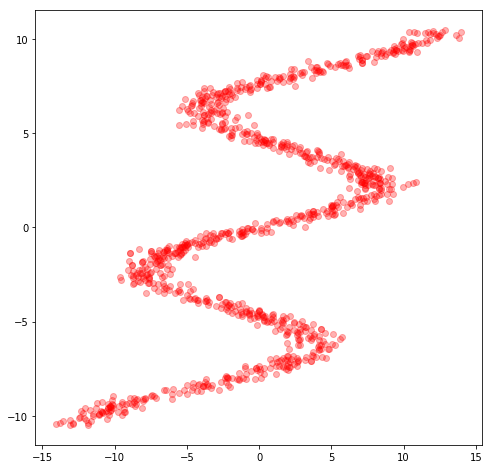

In [25]:
##############################################################
# 우리가 그린 그래프의 x, y를 뒤집어보자
##############################################################

temp_data = x_data
x_data = y_data
y_data = temp_data

plt.figure(figsize=(8, 8))
plot_out = plt.plot(x_data,y_data,'ro',alpha=0.3)
plt.show()

(210,)


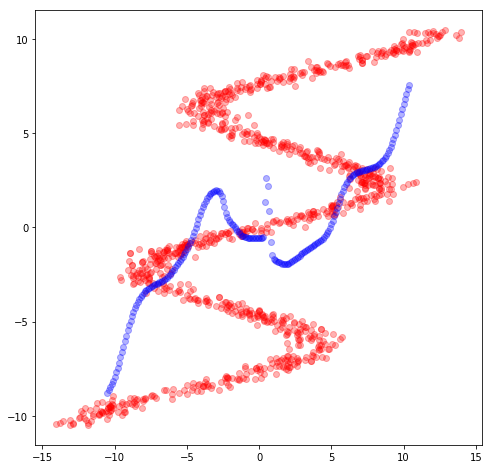

In [26]:
##############################################################
# 이 경우에는 MSE, 즉 tf.nn.l2_loss() 로 하면 답이 안나온다.
##############################################################

with tf.Session()  as sess:
    sess.run(tf.global_variables_initializer())

    # 학습
    NEPOCH = 1000
    for i in range(NEPOCH):
        sess.run(train_op, feed_dict={x: x_data, y: y_data})

    # 테스트
    x_test = np.float32(np.arange(-10.5, 10.5, 0.1))
    print(x_test.shape)
    x_test = x_test.reshape(x_test.size, 1)
    y_test = sess.run(y_out, feed_dict={x: x_test})

    plt.figure(figsize=(8, 8))
    plt.plot(x_data, y_data, 'ro', x_test, y_test, 'bo', alpha=0.3)
    plt.show()

### 위 그래프를 보자

1. 빨간색은 train set이다. 
2. 파란색은 우리가 학습한 네트워크로 x_test를 넣어 y_test를 뽑아낸 것이다

** 파란색 예측이 우리의 실제 데이터인 빨간색과 거의 맞지 않는다 **

    - 왜 이런 현상이 생길까?
    - 같은 x 값에 대하여 이 train set은 그때 그때 전혀 다른 y 값 라벨을 보여주며 학습시킨다
    - 결국 예측은 여러 y 값들의 평균즈음을 학습하여 예측하게 된다. 
    
### 우리가 원하는 것은 하나의 x 값에 대하여 여러 y값을 예측하고 그 중 하나를 선택하는 것이다. 

    - 다음 노트북에서 MDN - Mixtured Density Network를 들여다보자